In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Settings

In [2]:
DATA_PATH = "./data_sources/2025-11/SN2507190605.csv" 
RESAMPLE_RULE = "1min"

In [ ]:
# --- Data Loading and Preprocessing ---
def load_and_preprocess(path):
    # Load raw data
    df_raw = pd.read_csv(path)
    df_raw["dateTime"] = pd.to_datetime(df_raw["dateTime"], format="ISO8601", errors="coerce")
    df_raw = df_raw.dropna(subset=["dateTime"]).sort_values("dateTime").set_index("dateTime")
    
    # Metadata extraction
    charger_id = df_raw['systemId'].iloc[0] if 'systemId' in df_raw.columns else "Unknown"
    
    # Resample to 1-min continuity and handle missing power data
    df = df_raw.resample(RESAMPLE_RULE).agg({
        'charger_kw': 'mean',
        'v2g_kw': 'mean', 'v2h_kw': 'mean', 'g2v_kw': 'mean', 'h2v_kw': 'mean',
        'solar_kw': 'mean', 'consumption_kw': 'mean', 'grid_kw': 'mean'
    }).fillna(0)
    
    # Time-based features
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df['day_type'] = np.where(df.index.dayofweek >= 5, 'Weekend', 'Weekday')
    
    month_str = df.index.min().strftime('%B %Y')
    return df, charger_id, month_str

# Execute Loading
df, charger_id, month_str = load_and_preprocess(DATA_PATH)

# --- Profile Aggregations ---
power_cols = ['charger_kw', 'v2g_kw', 'v2h_kw', 'g2v_kw', 'h2v_kw', 'solar_kw', 'consumption_kw']
profile_agg = df.groupby('hour')[power_cols].mean()
profiles_split = df.groupby(['day_type', 'hour'])[power_cols].mean()

# RQ1 How do people use V2G during the trial?

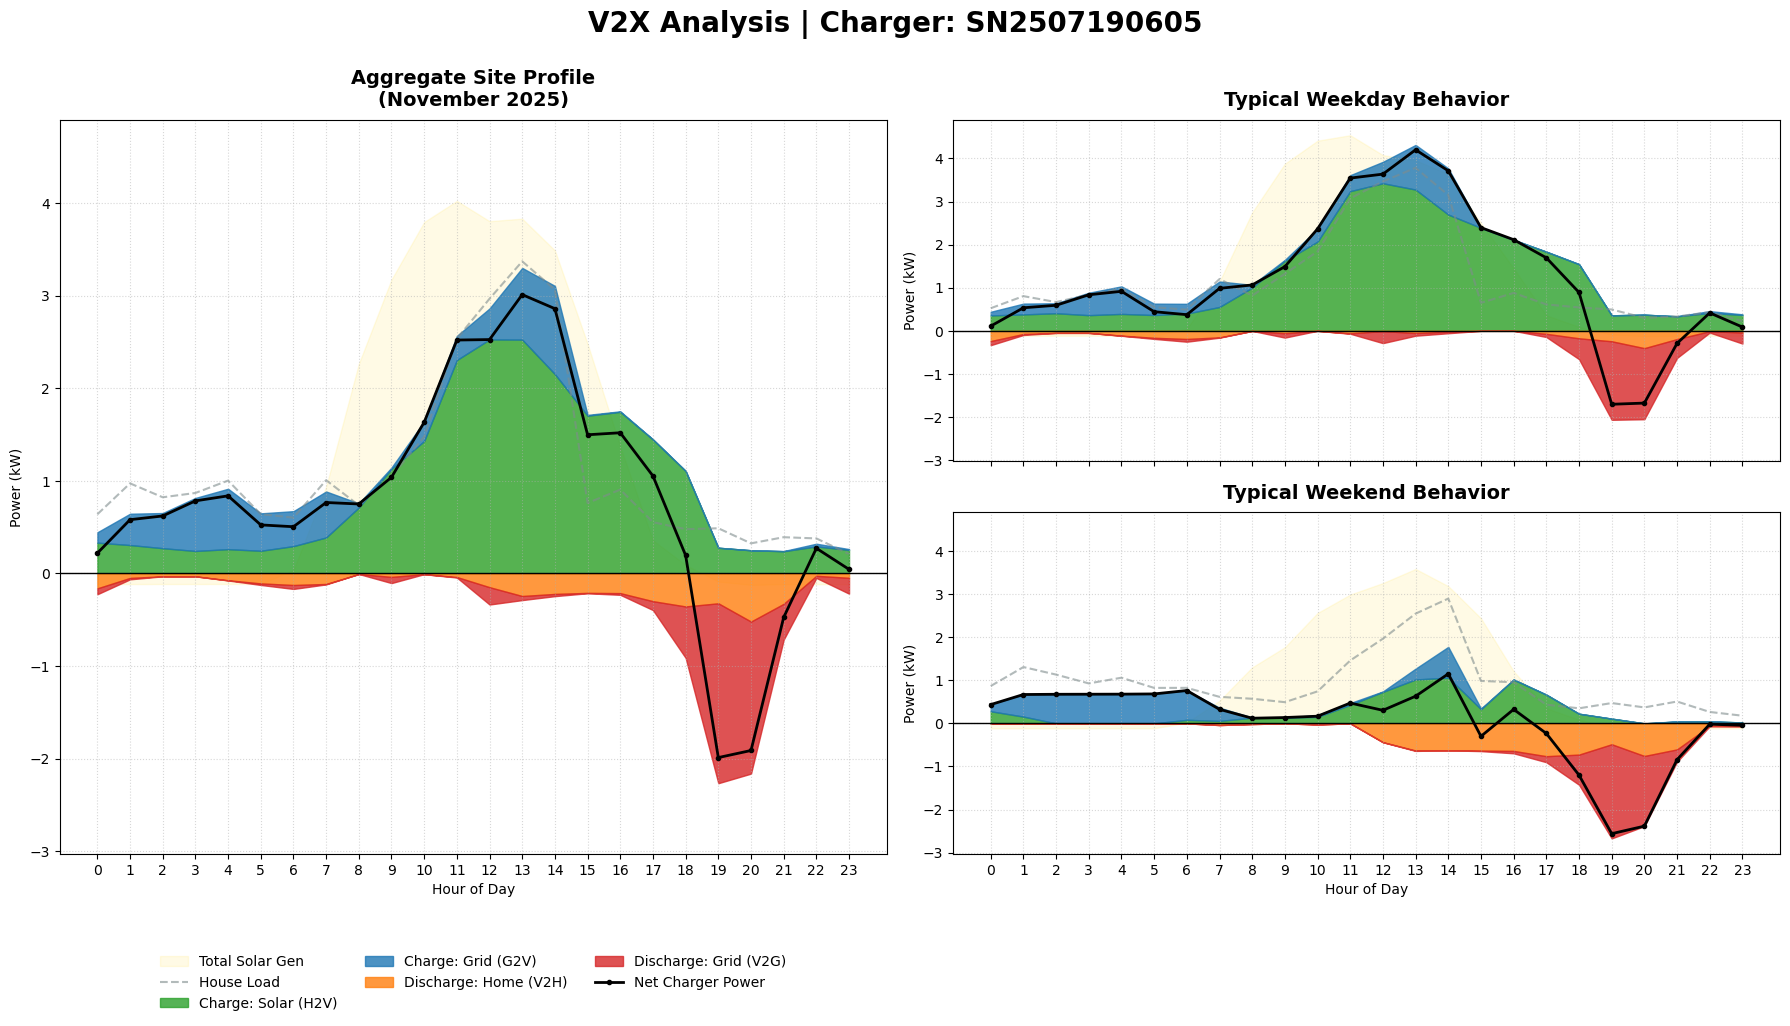

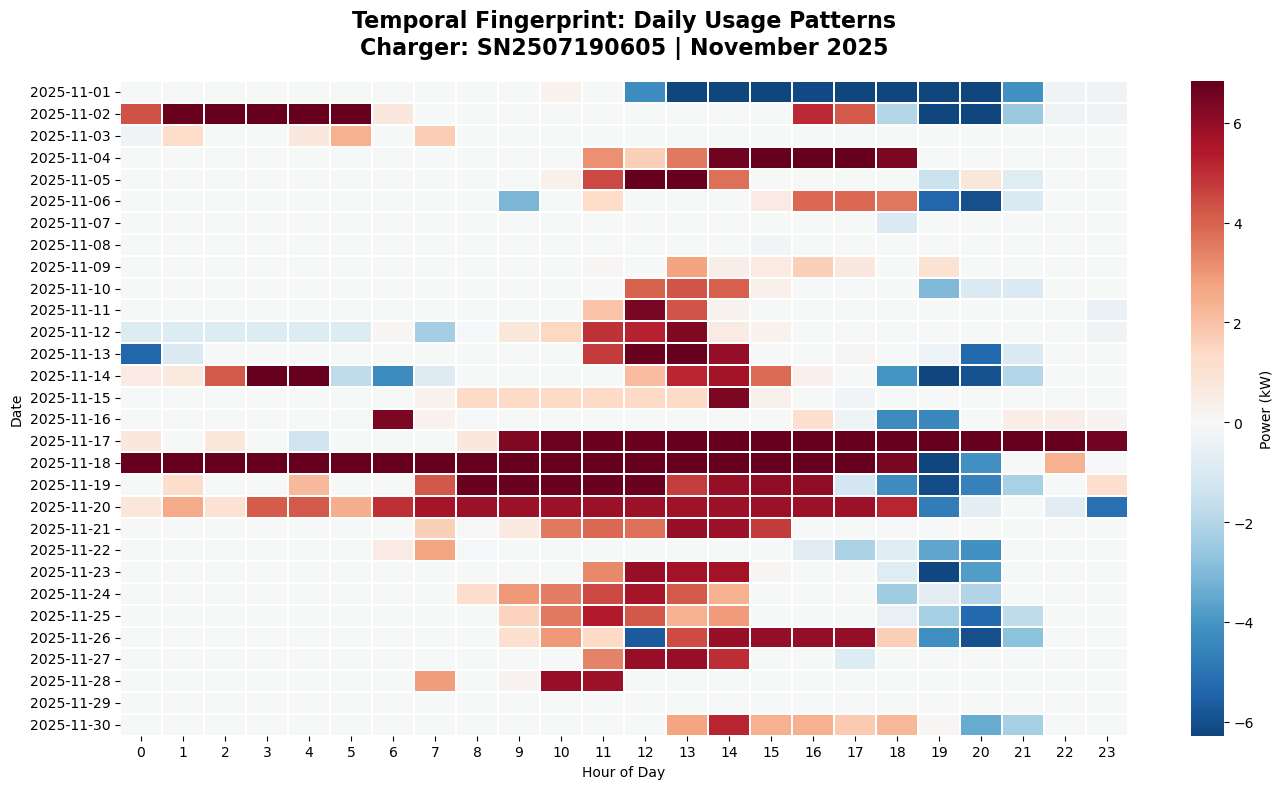

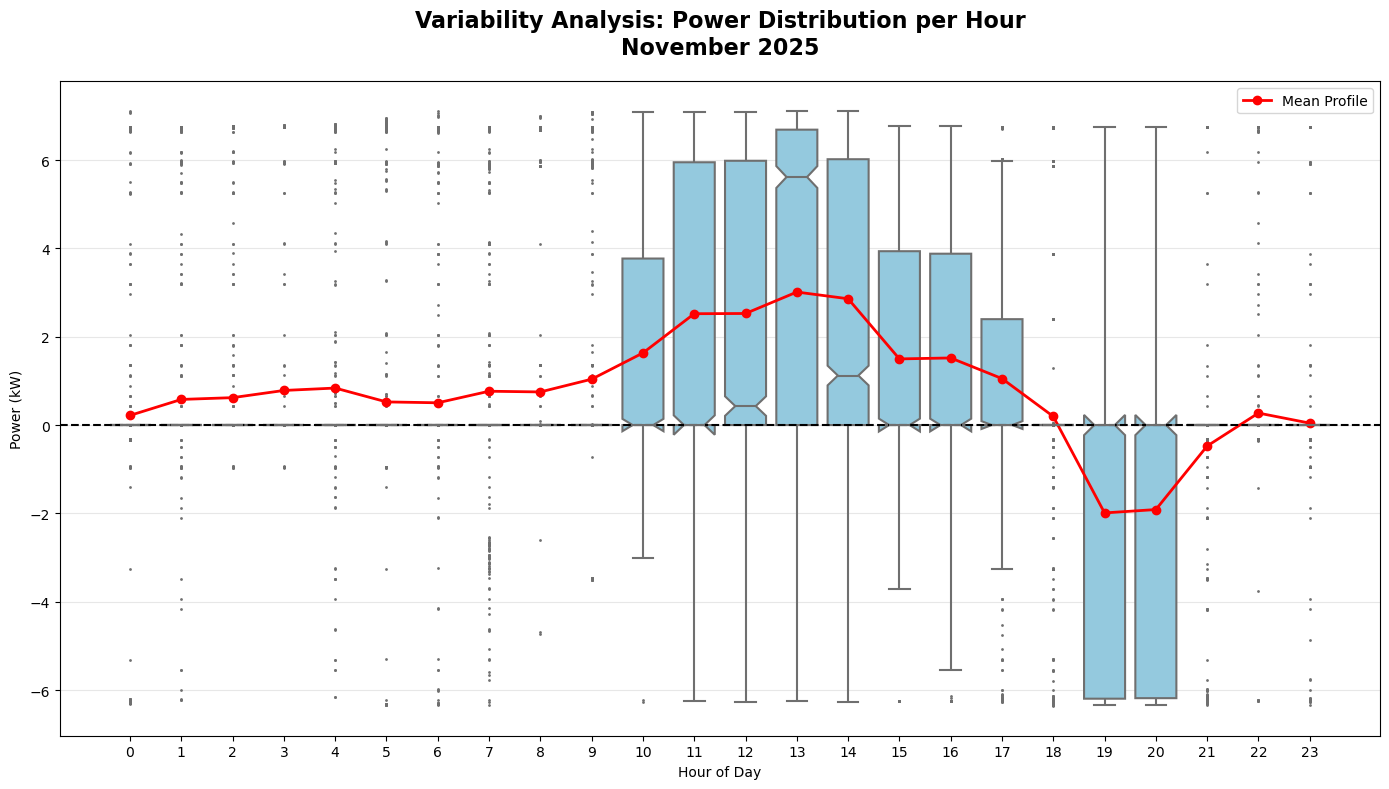

In [9]:
def plot_site_flows(ax, data, title, show_legend=False):
    """Utility to plot mirrored energy flows with site context."""
    # Background Reference: Solar and Consumption
    ax.fill_between(data.index, 0, data['solar_kw'], color='#FFD700', alpha=0.1, label='Total Solar Gen')
    ax.plot(data.index, data['consumption_kw'], color='#7f8c8d', linestyle='--', alpha=0.6, label='House Load')

    # Foreground Charger Flows: Positive (Charging)
    ax.fill_between(data.index, 0, data['h2v_kw'], label='Charge: Solar (H2V)', color='#2ca02c', alpha=0.8)
    ax.fill_between(data.index, data['h2v_kw'], data['h2v_kw'] + data['g2v_kw'], 
                     label='Charge: Grid (G2V)', color='#1f77b4', alpha=0.8)

    # Foreground Charger Flows: Negative (Discharging)
    ax.fill_between(data.index, 0, -data['v2h_kw'], label='Discharge: Home (V2H)', color='#ff7f0e', alpha=0.8)
    ax.fill_between(data.index, -data['v2h_kw'], -(data['v2h_kw'] + data['v2g_kw']), 
                     label='Discharge: Grid (V2G)', color='#d62728', alpha=0.8)

    # Net Power Line
    ax.plot(data.index, data['charger_kw'], color='black', linewidth=2, label='Net Charger Power', marker='o', markersize=3)

    # Formatting
    ax.axhline(0, color='black', linewidth=1)
    ax.set_title(title, fontsize=14, fontweight='bold', pad=10)
    ax.set_ylabel("Power (kW)")
    ax.set_xticks(range(0, 24))
    ax.grid(True, linestyle=':', alpha=0.5)
    if show_legend:
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3, frameon=False, fontsize=10)

# --- FIGURE 1: V2X SITE ANALYSIS (COMPREHENSIVE FLOWS) ---
fig1 = plt.figure(figsize=(18, 12))
gs = fig1.add_gridspec(2, 2)
ax_agg = fig1.add_subplot(gs[:, 0])
ax_wd = fig1.add_subplot(gs[0, 1], sharey=ax_agg)
ax_we = fig1.add_subplot(gs[1, 1], sharey=ax_agg, sharex=ax_wd)

plot_site_flows(ax_agg, profile_agg, f"Aggregate Site Profile\n({month_str})", show_legend=True)
plot_site_flows(ax_wd, profiles_split.loc['Weekday'], "Typical Weekday Behavior")
plot_site_flows(ax_we, profiles_split.loc['Weekend'], "Typical Weekend Behavior")

plt.setp(ax_wd.get_xticklabels(), visible=False)
ax_we.set_xlabel("Hour of Day")
ax_agg.set_xlabel("Hour of Day")
fig1.suptitle(f"V2X Analysis | Charger: {charger_id}", fontsize=20, fontweight='bold', y=0.95)
fig1.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

# --- FIGURE 2: TEMPORAL FINGERPRINT (HEATMAP) ---
plt.figure(figsize=(14, 8))
heatmap_data = df.pivot_table(index='date', columns='hour', values='charger_kw')
sns.heatmap(heatmap_data, cmap="RdBu_r", center=0, cbar_kws={'label': 'Power (kW)'}, linewidths=0.1)
plt.title(f"Temporal Fingerprint: Daily Usage Patterns\nCharger: {charger_id} | {month_str}", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Hour of Day")
plt.ylabel("Date")
plt.tight_layout()
plt.show()

# --- FIGURE 3: HOURLY VARIABILITY (BOXPLOT) ---
plt.figure(figsize=(14, 8))
sns.boxplot(x='hour', y='charger_kw', data=df, color='skyblue', fliersize=1, linewidth=1.5, notch=True)

# Overlay Mean Profile line for comparison
hourly_means = df.groupby('hour')['charger_kw'].mean()
plt.plot(hourly_means.index, hourly_means.values, color='red', marker='o', linestyle='-', linewidth=2, label='Mean Profile')

plt.axhline(0, color='black', linewidth=1.5, linestyle='--')
plt.title(f"Variability Analysis: Power Distribution per Hour\n{month_str}", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Hour of Day")
plt.ylabel("Power (kW)")
plt.grid(True, axis='y', alpha=0.3)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()